In [1]:
from CONSTANT import *
from tools import *
import pandas as pd
import numpy as np
from torch.utils.data import (TensorDataset, DataLoader, SequentialSampler, WeightedRandomSampler)

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoderLayer, TransformerDecoder
from torchmetrics import MeanSquaredError

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from models import *

import torch

from torch import nn
import torch.nn.functional as F
import gc


use_cuda = False
valid='loso'

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
print('using', device)

using cpu


In [2]:
from representation.PhySiRES import MultiSignalRepresentation
from models.MER import *

In [3]:
class Params(object):
    def __init__(self, lr=0.001, epoch=100, valid='loso', target='valence', batch_size=64,):
        self.batch_size = batch_size
        self.valid = valid
        self.target = target
        self.epoch = epoch
        self.lr = lr
        self.metrics_dict = {}
        self.debug = True
        self.out_channels = 32
        self.out_channels = 32
        self.hidden_size = 64
        self.num_layers = 1
        self.fcn_input = 50432
        self.dropout=0.2
        self.use_cuda=False
        self.device=torch.device(
            'cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')

In [ ]:
# spliter = load_model(r'./processed_signal/HKU956/400_12s_step_2s_spliter5.pkl')
# data = pd.read_pickle(r'./processed_signal/HKU956/400_4s_step_2s.pkl')
# data = pd.read_csv(r'./processed_signal/HKU956/400_4s_step_2s.csv')
spliter = load_model(r'./processed_signal/HKU956/772_12s_step_6s_spliter5.pkl')
data = pd.read_pickle(r'./processed_signal/HKU956/772_12s_step_6s.pkl')

for k in spliter[valid]:
    train_index = k['train_index']
    test_index = k['test_index']
    break

In [9]:
args = Params()
# dataprepare = DataPrepare(args=args, target='valence', data=data, train_index=train_index, test_index=test_index, device=args.device)
# # train_dataloader, test_dataloader = dataprepare.get_data()
# xtest = dataprepare.xtest
# xtrain = dataprepare.xtrain

# xtest.shape, xtrain.shape

In [6]:
xtest.shape

torch.Size([50, 4, 768])

In [7]:
del data, dataprepare
gc.collect()

0

In [10]:
signals = pd.read_pickle(r'./processed_signal/all_1536_24s_step_12s_sampled.pkl')
signals.shape

(136, 6146)

In [11]:
def concat_signals(df):
    bvp_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['BVP']
    ]
    eda_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['EDA']
    ]
    temp_cols = [
        fea for fea in df.columns.values if fea.split('_')[0] in ['TEMP']
    ]
    hr_cols = [fea for fea in df.columns.values if fea.split('_')[0] in ['HR']]

    signals = []
    for bvp, eda, temp, hr in zip(df[bvp_cols].values, df[eda_cols].values,
                                  df[temp_cols].values, df[hr_cols].values):
        signals.append([bvp, eda, temp, hr])

    return np.array(signals)

In [12]:
sig = concat_signals(signals)
sig.shape

(136, 4, 1536)

In [13]:
xtest = torch.from_numpy(sig).to(args.device).float()

In [14]:
model_ = MultiSignalRepresentation(seq=1536,
    output_size=40, pretrained=False, device=args.device)
model_.to(args.device)

model_.load_state_dict(torch.load(r'./representation/output/rep_1e-06_32_1681387016_maskp0.5/1e-06_32_maskp0.5_checkpoint.pt'))
for name, parameter in model_.named_parameters():
    parameter.requires_grad = False

In [15]:
mse_ = MeanSquaredError().to(args.device)

In [16]:
import matplotlib.pyplot as plt

def plot_signal(sig1, sig2, title):
    plt.figure(figsize=(7, 5))
    plt.plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
    plt.plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
    plt.legend(loc="upper left")
    plt.title(title)
    # plt.show()
    return plt.gca()

In [17]:
xtest[0].reshape(1, -1, 1536).shape

torch.Size([1, 4, 1536])

In [18]:
from tqdm import tqdm
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
all_mse = []

for i in tqdm(range(xtest.shape[0])):
    avg_mse = []
    for pred_signal, signal_name in enumerate(signal_names):
        channel_mask = [1, 1, 1, 1]
        channel_mask[pred_signal] = 0
        channel_mask = np.array([[i]*1536 for i in channel_mask]).reshape(1, -1, 1536)
        masked_signal = (xtest[i].reshape(1, -1, 1536).cpu().detach().numpy() * channel_mask)
        torch_masked_signal = torch.from_numpy(masked_signal).to(args.device).float()
        output = model_(torch_masked_signal)
        mse_res = mse_(output, torch_masked_signal).item()
        avg_mse.append(mse_res)
    all_mse.append(np.mean(avg_mse))
        # print('MSE', mse_res)

100%|██████████| 136/136 [03:16<00:00,  1.44s/it]


In [22]:
np.argmin(all_mse)

1

In [23]:
from sklearn.metrics import mean_squared_error

def mse_(s1, s2):
    return np.sqrt(mean_squared_error(s1, s2))

# Channel Mask

0.047231259101389214


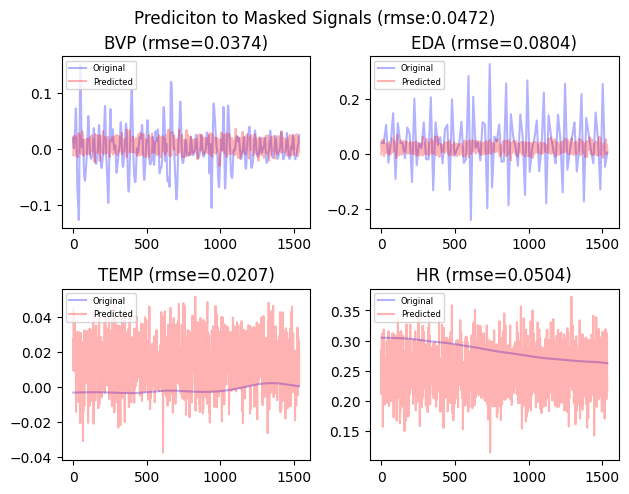

In [25]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = np.argmin(all_mse)
avg_res = []
fig, axs = plt.subplots(2, 2)
pred_signal = 0
for i in range(2):
    for j in range(2):
        signal_name = signal_names[pred_signal]
        channel_mask = [1, 1, 1, 1]
        channel_mask[pred_signal] = 0
        channel_mask = np.array([[i]*1536 for i in channel_mask]).reshape(1, -1, 1536)
        masked_signal = (xtest[signal_index].reshape(1, -1, 1536).cpu().detach().numpy() * channel_mask)
        torch_masked_signal = torch.from_numpy(masked_signal).to(args.device).float()
        output = model_(torch_masked_signal)
        # mse_res = np.sqrt(mse_(output, torch_masked_signal).item())
        
        sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
        sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
        mse_res = mse_(sig1, sig2)
        avg_res.append(mse_res)
        axs[i, j].plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
        axs[i, j].plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
        title = '{0} (rmse={1:.4f})'.format(signal_name, mse_res)

        axs[i, j].set_title(title)
        axs[i, j].legend(loc="upper left", fontsize=6, )
        fig.tight_layout()
        pred_signal += 1

fig.suptitle('Prediciton to Masked Signals (rmse:{:.4f})'.format(np.mean(avg_res)), y=1.02)
print(np.mean(avg_res))

# signal mask

In [26]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = 537
avg_res = []
for pred_signal, signal_name in enumerate(signal_names):
    # channel_mask = [1, 1, 1, 1]
    # channel_mask[pred_signal] = 0
    # channel_mask = np.array([[i]*1536 for i in channel_mask]).reshape(1, -1, 1536)
    signal_mask = (torch.rand((1, 4, 1536), device=args.device)
                       <= 0.8).int()
    masked_signal = (xtest[signal_index].reshape(1, -1, 1536) * signal_mask)
    torch_masked_signal = masked_signal.to(args.device).float()
    output = model_(torch_masked_signal)
    # mse_res = mse_(output, torch_masked_signal).item()
    # # print('MSE', mse_res)
    # avg_res.append(np.sqrt(mse_res))
    sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
    sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
    mse_res = mse_(sig1, sig2)
    avg_res.append(mse_res)
    plot_signal(sig1, sig2, '{0} Prediction Based on 80% masked Input Signals (rmse={1:.4f})'.format(signal_name, np.sqrt(mse_res)))
print(np.mean(avg_res))

IndexError: index 537 is out of bounds for dimension 0 with size 136

0.07216654412687665


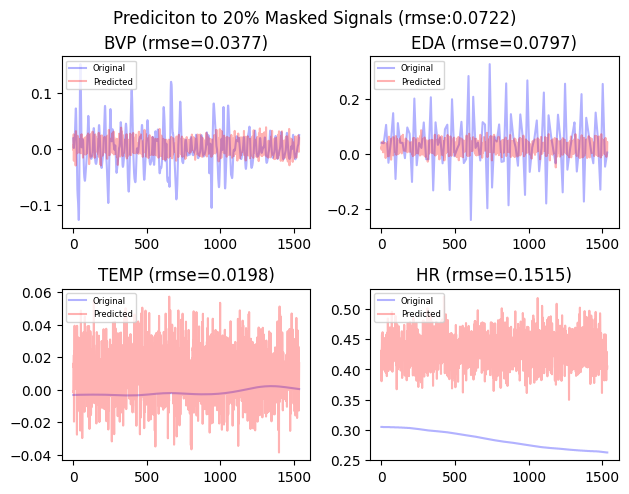

In [27]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = np.argmin(all_mse)
avg_res = []
fig, axs = plt.subplots(2, 2)
pred_signal = 0
for i in range(2):
    for j in range(2):
        signal_name = signal_names[pred_signal]
        signal_mask = (torch.rand((1, 4, 1536), device=args.device)
                       <= 0.8).int()
        masked_signal = (xtest[signal_index].reshape(1, -1, 1536) * signal_mask)
        torch_masked_signal = masked_signal.to(args.device).float()
        output = model_(torch_masked_signal)
        # mse_res = mse_(output, torch_masked_signal).item()
        # avg_res.append(np.sqrt(mse_res))
        sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
        sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
        mse_res = mse_(sig1, sig2)
        avg_res.append(mse_res)

        axs[i, j].plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
        axs[i, j].plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
        title = '{0} (rmse={1:.4f})'.format(signal_name, mse_res)

        axs[i, j].set_title(title)
        axs[i, j].legend(loc="upper left", fontsize=6, )
        fig.tight_layout()
        pred_signal += 1

fig.suptitle('Prediciton to 20% Masked Signals (rmse:{:.4f})'.format(np.mean(avg_res)), y=1.02)
print(np.mean(avg_res))

0.044597753230288584


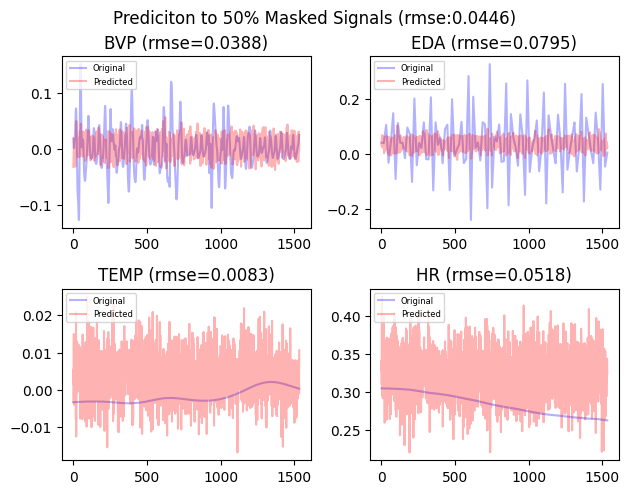

In [28]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = np.argmin(all_mse)
avg_res = []
fig, axs = plt.subplots(2, 2)
pred_signal = 0
for i in range(2):
    for j in range(2):
        signal_name = signal_names[pred_signal]
        signal_mask = (torch.rand((1, 4, 1536), device=args.device)
                       <= 0.5).int()
        masked_signal = (xtest[signal_index].reshape(1, -1, 1536) * signal_mask)
        torch_masked_signal = masked_signal.to(args.device).float()
        output = model_(torch_masked_signal)
        # mse_res = mse_(output, torch_masked_signal).item()
        # avg_res.append(np.sqrt(mse_res))
        sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
        sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
        mse_res = mse_(sig1, sig2)
        avg_res.append(mse_res)

        axs[i, j].plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
        axs[i, j].plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
        title = '{0} (rmse={1:.4f})'.format(signal_name, mse_res)

        axs[i, j].set_title(title)
        axs[i, j].legend(loc="upper left", fontsize=6, )
        fig.tight_layout()
        pred_signal += 1

fig.suptitle('Prediciton to 50% Masked Signals (rmse:{:.4f})'.format(np.mean(avg_res)), y=1.02)
print(np.mean(avg_res))

0.05521916964129388


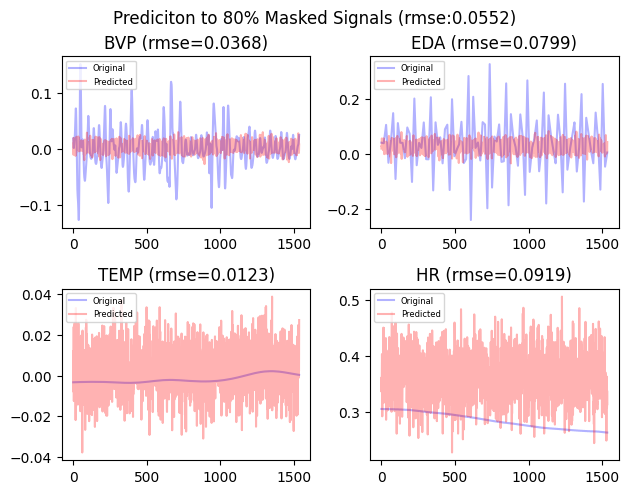

In [29]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = np.argmin(all_mse)
avg_res = []
fig, axs = plt.subplots(2, 2)
pred_signal = 0
for i in range(2):
    for j in range(2):
        signal_name = signal_names[pred_signal]
        signal_mask = (torch.rand((1, 4, 1536), device=args.device)
                       <= 0.2).int()
        masked_signal = (xtest[signal_index].reshape(1, -1, 1536) * signal_mask)
        torch_masked_signal = masked_signal.to(args.device).float()
        output = model_(torch_masked_signal)
        # mse_res = mse_(output, torch_masked_signal).item()
        # avg_res.append(np.sqrt(mse_res))
        sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
        sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
        mse_res = mse_(sig1, sig2)
        avg_res.append(mse_res)

        axs[i, j].plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
        axs[i, j].plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
        title = '{0} (rmse={1:.4f})'.format(signal_name, mse_res)

        axs[i, j].set_title(title)
        axs[i, j].legend(loc="upper left", fontsize=6, )
        fig.tight_layout()
        pred_signal += 1

fig.suptitle('Prediciton to 80% Masked Signals (rmse:{:.4f})'.format(np.mean(avg_res)), y=1.02)
print(np.mean(avg_res))

# Full input

0.04877340427063341


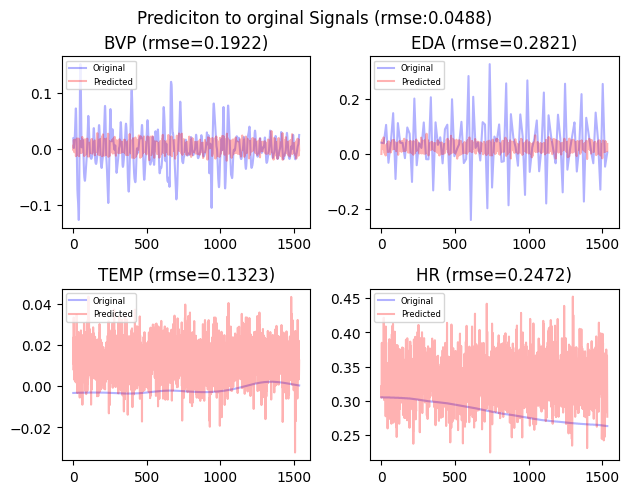

In [31]:
signal_names = ['BVP', 'EDA', 'TEMP', 'HR']
signal_index = np.argmin(all_mse)
avg_res = []
fig, axs = plt.subplots(2, 2)
pred_signal = 0
for i in range(2):
    for j in range(2):
        signal_name = signal_names[pred_signal]
        
        torch_masked_signal = xtest[signal_index].reshape(1, -1, 1536).to(args.device).float()
        output = model_(torch_masked_signal)
        # mse_res = mse_(output, torch_masked_signal).item()
        # avg_res.append(np.sqrt(mse_res))
        sig2 = output.cpu().detach().numpy()[0][pred_signal].tolist()
        sig1 = xtest.cpu().detach().numpy()[signal_index][pred_signal].tolist()
        mse_res = mse_(sig1, sig2)
        avg_res.append(mse_res)

        axs[i, j].plot(range(len(sig1)), sig1, color='blue', alpha=0.3, label="Original")
        axs[i, j].plot(range(len(sig2)), sig2, '-', color='red', alpha=0.3, label="Predicted")
        title = '{0} (rmse={1:.4f})'.format(signal_name, np.sqrt(mse_res))

        axs[i, j].set_title(title)
        axs[i, j].legend(loc="upper left", fontsize=6, )
        fig.tight_layout()
        pred_signal += 1

fig.suptitle('Prediciton to orginal Signals (rmse:{:.4f})'.format(np.mean(avg_res)), y=1.02)
print(np.mean(avg_res))

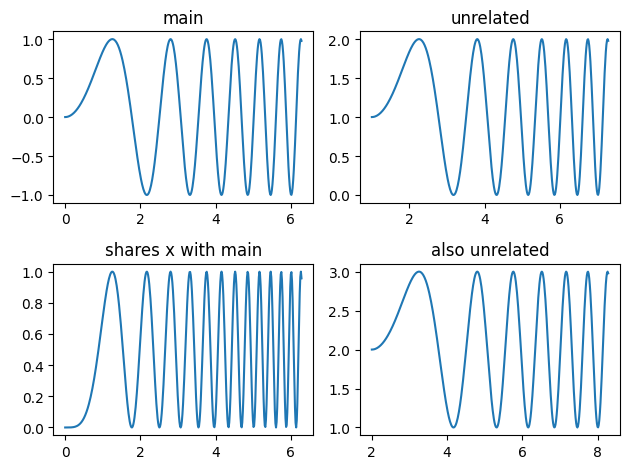

In [126]:
# fig, axs = plt.subplots(2, 2)
# x = np.linspace(0, 2 * np.pi, 400)
# y = np.sin(x ** 2)
# axs[0, 0].plot(x, y)
# axs[0, 0].set_title("main")
# axs[1, 0].plot(x, y**2)
# axs[1, 0].set_title("shares x with main")
# axs[1, 0].sharex(axs[0, 0])
# axs[0, 1].plot(x + 1, y + 1)
# axs[0, 1].set_title("unrelated")
# axs[1, 1].plot(x + 2, y + 2)
# axs[1, 1].set_title("also unrelated")
# fig.tight_layout()